<a href="https://colab.research.google.com/github/GregUOC/Data-Science-projects/blob/main/Handwritten_names_Recognition_OCR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import log_softmax
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import os
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr'
# Using opendatasets let's download the data sets
od.download(dataset)
#c1f1e184253480b50d517255da2d12d1

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gregorypachis
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr


100%|██████████| 1.26G/1.26G [00:18<00:00, 74.7MB/s]

In [ ]:
# Define paths for training, testing, and validation datasets
imgtrain_dir = '/content/handwriting-recognitionocr/train_v2/train'
imgtest_dir = '/content/handwriting-recognitionocr/test_v2/test'
imgval_dir = '/content/handwriting-recognitionocr/validation_v2/validation'

train_csv = '/content/handwriting-recognitionocr/CSV/written_name_train.csv'
test_csv = '/content/handwriting-recognitionocr/CSV/written_name_test.csv'
val_csv = '/content/handwriting-recognitionocr/CSV/written_name_validation.csv'

# Function to collect unique characters from the dataset
def collect_unique_characters(csv_file):
    data = pd.read_csv(csv_file)
    all_chars = set()

    for label in data.iloc[:, 1]:
        if isinstance(label, str):
            all_chars.update(label)

    return sorted(all_chars)

# Collect unique characters from all datasets
train_chars = collect_unique_characters(train_csv)
test_chars = collect_unique_characters(test_csv)
val_chars = collect_unique_characters(val_csv)


all_chars = sorted(set(train_chars).union(test_chars).union(val_chars))  # Ensure the union is sorted
print(f"Unique characters in the dataset: {all_chars}")

# Update char_to_num dictionary with a fixed order
char_to_num = {char: idx for idx, char in enumerate(all_chars)}
print(f"Updated char_to_num dictionary: {char_to_num}")
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.filtered_indices = []  # Store indices of filtered out samples

        # Filter out samples with float target labels that have no length
        for idx, label in enumerate(self.data.iloc[:, 1]):
            try:
                if len(label) == 0 and isinstance(label, float):
                    self.filtered_indices.append(idx)
            except TypeError:
                pass

    def __len__(self):
        return len(self.data) - len(self.filtered_indices)

    def __getitem__(self, idx):
        # Adjust index to skip filtered out samples
        for filtered_idx in self.filtered_indices:
            if idx >= filtered_idx:
                idx += 1
            else:
                break

        img_name = self.data.iloc[idx, 0]  # Assuming the first column contains image names
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        # Normalize pixel values to range [0, 1] and convert image to tensor
        image = transforms.ToTensor()(image)

        # Get target label
        target_label = self.data.iloc[idx, 1]  # Assuming the second column contains target labels
        target_label = str(self.data.iloc[idx, 1])

        # Convert target label to tensor of character indices
        target_label_tensor = torch.tensor(
            [char_to_num[char] for char in target_label], dtype=torch.long
        )

        # Get target length (for variable sequence lengths if needed)
        target_length_tensor = torch.tensor(len(target_label), dtype=torch.long)

        return image, target_label_tensor, target_length_tensor

# Custom collate function
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    target_labels = [item[1] for item in batch]
    target_lengths = [item[2] for item in batch]

    images = torch.stack(images, dim=0)

    target_labels_padded = pad_sequence(target_labels, batch_first=True, padding_value=len(char_to_num))
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return images, target_labels_padded, target_lengths

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 128)),
])



# Create custom datasets
train_dataset = CustomDataset(imgtrain_dir, train_csv, transform=transform)
test_dataset = CustomDataset(imgtest_dir, test_csv, transform=transform)
val_dataset = CustomDataset(imgval_dir, val_csv, transform=transform)

# Create dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

Unique characters in the dataset: [' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z']
Updated char_to_num dictionary: {' ': 0, "'": 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, '`': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'y': 49, 'z': 50}


In [ ]:
train_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([ 4,  3, 14, 22, 10,  3, 28,  3, 20]),
 tensor(9))

Unique characters in the dataset: [' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z']
Updated char_to_num dictionary: {' ': 0, "'": 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, '`': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'y': 49, 'z': 50}
Epoch: 1, Batch: 0, Loss: 52.26549530029297
Epoch: 1, Batch: 200, Loss: 3.2866482734680176
Epoch: 1, Batch: 400, Loss: 3.2366323471069336
Epoch: 1, Batch: 600, Loss: 3.151033401489258
Epoch: 1, Batch: 800, Loss: 3.12224864959716

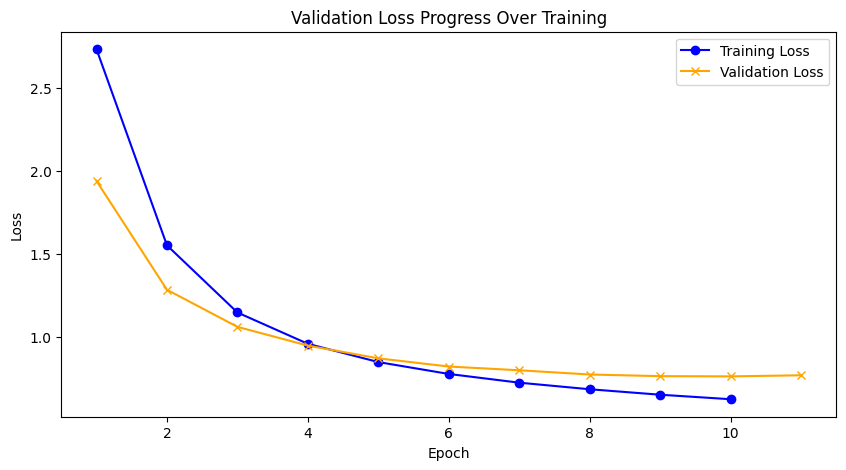

In [ ]:
# Define paths for training, testing, and validation datasets

imgtrain_dir = '/content/handwriting-recognitionocr/train_v2/train'
imgtest_dir = '/content/handwriting-recognitionocr/test_v2/test'
imgval_dir = '/content/handwriting-recognitionocr/validation_v2/validation'

train_csv = '/content/handwriting-recognitionocr/CSV/written_name_train.csv'
test_csv = '/content/handwriting-recognitionocr/CSV/written_name_test.csv'
val_csv = '/content/handwriting-recognitionocr/CSV/written_name_validation.csv'

# Function to collect unique characters from the dataset
def collect_unique_characters(csv_file):
    data = pd.read_csv(csv_file)
    all_chars = set()

    for label in data.iloc[:, 1]:
        if isinstance(label, str):
            all_chars.update(label)

    return sorted(all_chars)

# Collect unique characters from all datasets
train_chars = collect_unique_characters(train_csv)
test_chars = collect_unique_characters(test_csv)
val_chars = collect_unique_characters(val_csv)


all_chars = sorted(set(train_chars).union(test_chars).union(val_chars))  # Ensure the union is sorted
print(f"Unique characters in the dataset: {all_chars}")

# Update char_to_num dictionary with a fixed order
char_to_num = {char: idx for idx, char in enumerate(all_chars)}
print(f"Updated char_to_num dictionary: {char_to_num}")
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.filtered_indices = []  # Store indices of filtered out samples

        # Filter out samples with float target labels that have no length
        for idx, label in enumerate(self.data.iloc[:, 1]):
            try:
                if len(label) == 0 and isinstance(label, float):
                    self.filtered_indices.append(idx)
            except TypeError:
                pass

    def __len__(self):
        return len(self.data) - len(self.filtered_indices)

    def __getitem__(self, idx):
        # Adjust index to skip filtered out samples
        for filtered_idx in self.filtered_indices:
            if idx >= filtered_idx:
                idx += 1
            else:
                break

        img_name = self.data.iloc[idx, 0]  # Assuming the first column contains image names
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        # Normalize pixel values to range [0, 1] and convert image to tensor
        image = transforms.ToTensor()(image)

        # Get target label
        target_label = self.data.iloc[idx, 1]  # Assuming the second column contains target labels
        target_label = str(self.data.iloc[idx, 1])

        # Convert target label to tensor of character indices
        target_label_tensor = torch.tensor(
            [char_to_num[char] for char in target_label], dtype=torch.long
        )

        # Get target length (for variable sequence lengths if needed)
        target_length_tensor = torch.tensor(len(target_label), dtype=torch.long)

        return image, target_label_tensor, target_length_tensor

# Define the OCRModel class
class OCRModel(nn.Module):
    def __init__(self, num_classes):
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 256, 128)
        self.lstm = nn.LSTM(128, 64, bidirectional=True, batch_first=True)
        self.fc2 = nn.Linear(64 * 2, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.unsqueeze(1).repeat(1, 90, 1)#(this controls the number of timesteps)
        x, _ = self.lstm(x)
        x = self.fc2(x)
        return x

# Custom collate function
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    target_labels = [item[1] for item in batch]
    target_lengths = [item[2] for item in batch]

    images = torch.stack(images, dim=0)

    target_labels_padded = pad_sequence(target_labels, batch_first=True, padding_value=len(char_to_num))
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return images, target_labels_padded, target_lengths

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 128)),
])



# Create custom datasets
train_dataset = CustomDataset(imgtrain_dir, train_csv, transform=transform)
test_dataset = CustomDataset(imgtest_dir, test_csv, transform=transform)
val_dataset = CustomDataset(imgval_dir, val_csv, transform=transform)

# Create dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

# Instantiate the model
num_classes = len(char_to_num) + 1  # +1 for the CTC blank label
model = OCRModel(num_classes)

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CTC Loss
criterion = nn.CTCLoss(blank=num_classes - 1, reduction='mean')

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to the device
model.to(device)
'''
'''
# Lists to store losses
train_losses = []
val_losses = []

# Training function
def train(model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets, target_lengths) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        # Flatten targets
        targets_flattened = torch.cat([t[:length] for t, length in zip(targets, target_lengths)])

        optimizer.zero_grad()
        outputs = model(inputs)

        # Prepare CTC loss inputs
        input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long).to(device)

        outputs = log_softmax(outputs, 2)
        loss = criterion(outputs.permute(1, 0, 2), targets_flattened, input_lengths, target_lengths)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch}, Training Loss: {avg_loss}')
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets, target_lengths in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            # Flatten targets
            targets_flattened = torch.cat([t[:length] for t, length in zip(targets, target_lengths)])

            outputs = model(inputs)

            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long).to(device)

            outputs = log_softmax(outputs, 2)
            loss = criterion(outputs.permute(1, 0, 2), targets_flattened, input_lengths, target_lengths)

            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    val_losses.append(avg_loss)
    print(f'Validation Loss: {avg_loss}')
    return avg_loss

# Training Loop
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, criterion, optimizer, epoch, device)
    evaluate(model, val_loader, criterion, device)
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
# Evaluate on test set
evaluate(model, test_loader, criterion, device)

# Plotting the loss progress
print(f"Number of epochs: {num_epochs}")
print(f"Validation losses: {val_losses}")
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Progress Over Training')
plt.legend()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def decode_sequence(sequence, num_to_char):
    return ''.join([num_to_char[idx] for idx in sequence if idx in num_to_char])

def get_predictions_and_labels(model, data_loader, device, char_to_num):
    model.eval()
    predictions = []
    labels = []
    num_to_char = {v: k for k, v in char_to_num.items()}  # Reverse the mapping

    with torch.no_grad():
        for images, target_labels, target_lengths in data_loader:
            images = images.to(device)
            outputs = model(images)

            # Get the most probable characters
            _, preds = torch.max(outputs, 2)
            preds = preds.permute(1, 0).cpu().numpy()  # (sequence_length, batch_size)

            for i in range(len(target_labels)):
                decoded_pred = decode_sequence(preds[:, i], num_to_char)
                decoded_label = decode_sequence(target_labels[i].cpu().numpy(), num_to_char)

                predictions.append(decoded_pred)
                labels.append(decoded_label)

                # Debugging information
                print(f"Predicted: {decoded_pred}")
                print(f"Label: {decoded_label}")

    return predictions, labels

def count_character_predictions(predictions, labels, char_to_num):
    # Initialize dictionaries to track correct and false predictions for each character
    correct_counts = {char: 0 for char in char_to_num.keys()}
    incorrect_counts = {char: 0 for char in char_to_num.keys()}

    for pred, label in zip(predictions, labels):
        # Match characters in predicted and label sequences
        for p_char, l_char in zip(pred, label):
            if p_char == l_char:
                correct_counts[l_char] += 1
            else:
                incorrect_counts[l_char] += 1

    return correct_counts, incorrect_counts

def print_character_statistics(correct_counts, incorrect_counts):
    # Print statistics for each character
    for char in correct_counts.keys():
        correct = correct_counts[char]
        incorrect = incorrect_counts[char]
        print(f"Character: '{char}' | Correct: {correct}, Incorrect: {incorrect}")

# Get predictions and labels from the model
predictions, labels = get_predictions_and_labels(model, val_loader, device, char_to_num)

# Count how many times each character was predicted correctly and incorrectly
correct_counts, incorrect_counts = count_character_predictions(predictions, labels, char_to_num)

# Print the statistics for each character
print_character_statistics(correct_counts, incorrect_counts)



Streaming output truncated to the last 5000 lines.
Label: MAXIM
Predicted: DARIAAN
Label: DORIAN
Predicted: CLEMEENNT
Label: CLEMENT
Predicted: HENOR
Label: AENOR
Predicted: QUENNTIIN
Label: QUENTIN
Predicted: YVAN
Label: YVAN
Predicted: ANTOOIINE
Label: ANTOINE
Predicted: MATMES
Label: MATHEO
Predicted: TYVOIER
Label: TYWONIUK
Predicted: CCMRRLLLE
Label: CHARLIE
Predicted: LIROY
Label: LIROY
Predicted: LERRAAAND
Label: LEGRAND
Predicted: MARLI
Label: HABLI
Predicted: SEHRREN
Label: SCHREINER
Predicted: LEIAA
Label: ELISA
Predicted: BOIRRIE
Label: DOIBRIL
Predicted: PLAMCCCOOO
Label: PLANCHON
Predicted: PEREISSSSNEE
Label: PERISSIN-FABERI
Predicted: CHARENIIER
Label: CHARPENTIER
Predicted: AUDREEY
Label: AUDREY
Predicted: NICOOLAS
Label: NICOLAS
Predicted: DESNNALLE
Label: DESMULIE
Predicted: BARTIIITE
Label: BAPTISTE
Predicted: LEFEEIRE
Label: LEFABURE
Predicted: HEUDIAARD
Label: HEUDIARD
Predicted: FITEET
Label: FINET
Predicted: CAOOOUY
Label: CADOUX
Predicted: MARIIS
Label: PARZYSZ


In [ ]:
model_path = '/content/model_epoch_5.pth'

# Load the saved state dictionary with CPU mapping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


<ipython-input-6-8fddbd98fb72>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def decode_sequence(sequence, num_to_char):
    return ''.join([num_to_char[idx] for idx in sequence if idx in num_to_char])

def get_predictions_and_labels(model, data_loader, device, char_to_num):
    model.eval()
    predictions = []
    labels = []
    num_to_char = {v: k for k, v in char_to_num.items()}  # Reverse the mapping

    with torch.no_grad():
        for images, target_labels, target_lengths in data_loader:
            images = images.to(device)
            outputs = model(images)

            # Get the most probable characters
            _, preds = torch.max(outputs, 2)
            preds = preds.permute(1, 0).cpu().numpy()  # (sequence_length, batch_size)

            for i in range(len(target_labels)):
                decoded_pred = decode_sequence(preds[:, i], num_to_char)
                decoded_label = decode_sequence(target_labels[i].cpu().numpy(), num_to_char)

                predictions.append(decoded_pred)
                labels.append(decoded_label)

    return predictions, labels
def calculate_sequence_accuracy(predictions, labels):
    correct_count = sum(1 for pred, label in zip(predictions, labels) if pred == label)
    total_count = len(predictions)
    return correct_count / total_count

def calculate_character_accuracy(predictions, labels):
    correct_char_count = 0
    total_char_count = 0

    for pred, label in zip(predictions, labels):
        for p_char, l_char in zip(pred, label):
            if p_char == l_char:
                correct_char_count += 1
            total_char_count += 1

    return correct_char_count / total_char_count

# Get predictions and labels from the model
predictions, labels = get_predictions_and_labels(model, val_loader, device, char_to_num)

# Calculate and print sequence-level accuracy
sequence_accuracy = calculate_sequence_accuracy(predictions, labels)
print(f'Sequence-level Accuracy: {sequence_accuracy * 100:.2f}%')

# Calculate and print character-level accuracy
character_accuracy = calculate_character_accuracy(predictions, labels)
print(f'Character-level Accuracy: {character_accuracy * 100:.2f}%')

2c1lstm k3,k3,dropout=0
*   Epoch 10 Training Loss: 0.6359163262612674 Validation Loss: 0.7523340733932011 Sequence-level Accuracy: 33.80%
Character-level Accuracy: 73.70%
*   Epoch: 15, Training Loss: 0.6190622765729341
Validation Loss: 0.7002167593935358 Sequence-level Accuracy: 38.51%
Character-level Accuracy: 76.70%

2c1lstm out=32 k5,out=128 k3 dropout=0.2


*   Epoch10 Epoch: 10, Training Loss: 0.7885618948961817
Validation Loss: 0.715853467975186


